In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import chisquare

from collections import Counter


In [6]:
def fix(s):
    firstcolon = s.find(":")
    s_new = s[firstcolon-2:firstcolon] + s[firstcolon+1:firstcolon+3]
    s_new = s_new.replace("*", "0")
    return s_new

def compute_resolution(gs_val,pre_val):
    gs_all = gs_val.split("/")
    pre_fixed = fix(pre_val)
    flag = False #false = inaccurate, turn to true = 2 digits accurate
    
    for val in gs_all:
        gs_fixed = fix(val)

        if (gs_fixed[0:2] == pre_fixed[0:2]):
            if (gs_fixed[2:4] == pre_fixed[2:4]):
                return 4
            flag = True
        
    return 2 if flag==True else 0

In [7]:
# requirements: gs accession numbers are under a column labeled "Run" 
#pre accession numbers are under a column labeled "ERR" 
# accession numbers/column titles are labeled identically between gold standard and results csv
# Only accuracy for samples in both GS and PRE are calculated. Samples in PRE, but not in GS are ignored. Samples in GS, but not in PRE, are tallied in the "failed" variable 
def get_inaccurate_alleles(pre,gs):

    zerodig = []
    fail = 0

    accession_numbers = gs['Run'].values.tolist()
    genes = gs.columns.values.tolist()

    for number in accession_numbers:
        pre_row = pre.loc[pre['ERR'] == number]
        gs_row = gs.loc[gs['Run'] == number]
    
        for i in range(1,len(genes),2):
            try:
                gs_val1 = gs_row[genes[i]].astype(str).values[0]
                pre_val1 = pre_row[genes[i]].astype(str).values[0]
                gs_val2 = gs_row[genes[i+1]].astype(str).values[0]
                pre_val2 = pre_row[genes[i+1]].astype(str).values[0]
                
                # if the gold standard contains many allele possibilities, and the caller is incorrect,
                # we will return only the first value in the gs
                gs_primary = gs_row[genes[i]].astype(str).values[0].split("/")[0]

                if (gs_val1 == None) or (pre_val1 == None) or (gs_val2 == None) or (pre_val2 == None):
                    fail = fail+1
                    continue

                # assuming no swapping 
                ans1 = compute_resolution(gs_val1,pre_val1)
                ans2 = compute_resolution(gs_val2,pre_val2)

                # assuming swapping
                ans3 = compute_resolution(gs_val1,pre_val2)
                ans4 = compute_resolution(gs_val2,pre_val1)

                if (ans1+ans2 > ans3+ans4):
                    if (ans1 == 0):
                        zerodig.append(gs_primary)
                    if (ans2 == 0):
                        zerodig.append(gs_primary)
                else:
                    if (ans3 == 0):
                        zerodig.append(gs_primary)
                    if (ans4 == 0):
                        zerodig.append(gs_primary)
            except:
                fail = fail+1

    return zerodig #,fail #onzero fail indicates exception occurred

In [8]:
data = list()

In [9]:
# to sum the 4 European ancestry groups into 1 European ancestry
def sum_euro_groups(data):
    ret = []
    for group in data:
        for allele in group:
            ret.append(allele)
    return ret

In [10]:
def missed_alleles_per_ancestry(pre,gs):
    groupscsv = "../datasets/SraRunTableD2.txt"
    groups = pd.read_csv(groupscsv)
    
    results = []

    for group, df_by_group in groups.groupby('Population'):
        accession_numbers = df_by_group['Run'].values.tolist()
        gs_final = gs[gs['Run'].isin(accession_numbers)] #gs_final is a df containing the gold standard samples per population group
        gs_final = gs_final.iloc[: ,:]
        

        ret = get_inaccurate_alleles(pre,gs_final)
        results.append(ret)

    yorubaresult = results[4]
    europeanresult = sum_euro_groups(results[1:4])

    return yorubaresult, europeanresult

In [11]:
data = list()
tools=["hlaforest","optitype","phlat","seq2hla","rna2hla","arcas","hlavbseq","hlahd"]

yoruba_missed_alleles = []
europe_missed_alleles = []

for t in tools:
    gs=pd.read_csv("../datasets/2_gs.csv")
    pre=pd.read_csv("../results/standard/"+str(t)+"_d2.csv")
        
    results = missed_alleles_per_ancestry(pre,gs)
    
    for i in results[0]:
        yoruba_missed_alleles.append(i)
    for i in results[1]:
        europe_missed_alleles.append(i)
    



In [12]:
ycounts = Counter(yoruba_missed_alleles)
ecounts = Counter(europe_missed_alleles)

print(ycounts)
print(ecounts)

Counter({'DQB1*02:01': 55, 'DQB1*06:03': 34, 'DQB1*05:01': 31, 'DQB1*06:02': 30, 'DRB1*11:04': 25, 'DQB1*05:02': 21, 'DRB1*15:03': 19, 'DQB1*06:05': 16, 'DRB1*13:01': 16, 'B*53:01:00': 15, 'DQB1*04:02': 15, 'C*04:01': 14, 'DRB1*13:03': 14, 'DRB1*08:04': 13, 'B*42:01:00': 12, 'DRB1*13:02': 12, 'DRB1*03:01': 12, 'B*52:01:00': 11, 'B*35:01:00': 10, 'DRB1*14:01': 9, 'DRB1*07:01': 9, 'DQB1*06:04': 8, 'DRB1*01:01': 8, 'A*24:24:00': 6, 'B*41:04:00': 6, 'DRB1*03:02': 6, 'B*15:10': 5, 'DRB1*11:01': 5, 'C*07:01': 5, 'A*30:02:00': 5, 'A*23:01': 4, 'B*51:01:00': 4, 'DQB1*03:01': 4, 'B*07:02': 4, 'DRB1*12:01': 4, 'DRB1*13:35': 4, 'B*18:01': 3, 'DQB1*05:03': 3, 'A*02:01': 3, 'A*03:01': 3, 'B*15:03': 2, 'B*42:02:00': 2, 'C*02:02': 2, 'DRB1*01:02': 2, 'A*29:02:00': 2, 'B*13:02': 2, 'C*17:01': 2, 'B*35:01': 1, 'C*01:02': 1, 'A*26:01:00': 1, 'A*02:05': 1, 'C*07:02': 1, 'A*30:01:00': 1, 'A*01:01': 1})
Counter({'DQB1*02:01': 334, 'DRB1*15:01': 196, 'DQB1*03:01': 180, 'DQB1*03:02': 151, 'DRB1*01:01': 145, 

In [35]:
allele_intersection = list(set(ycounts.keys()) & set(ecounts.keys()))

intersection = []

for allele in allele_intersection:
    intersection.append([allele,ycounts[allele],ecounts[allele],(ecounts[allele]+ycounts[allele])/2])

df = pd.DataFrame (intersection, columns = ['allele','yoruba','Europe','avg'])
df = df.sort_values(by=['avg'],ascending=False)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

        allele  yoruba  Europe    avg
30  DQB1*02:01      55     334  194.5
3   DQB1*03:01       4     180   92.0
28  DRB1*01:01       8     145   76.5
24  DQB1*05:01      31      78   54.5
9   DQB1*04:02      15      81   48.0
0   DQB1*06:02      30      63   46.5
26  DRB1*03:01      12      71   41.5
13     C*04:01      14      54   34.0
14     A*02:01       3      61   32.0
7   DRB1*07:01       9      52   30.5
12  DRB1*11:04      25      31   28.0
22  DRB1*11:01       5      48   26.5
2   DRB1*13:01      16      28   22.0
27  DQB1*06:03      34      10   22.0
19  DQB1*05:02      21      11   16.0
15     B*35:01       1      29   15.0
31  DRB1*13:02      12      16   14.0
11     B*07:02       4      23   13.5
20  DRB1*14:01       9      17   13.0
1   DRB1*13:03      14       9   11.5
16     A*03:01       3      20   11.5
21     C*07:01       5      16   10.5
18     A*01:01       1      18    9.5
6   DQB1*05:03       3      13    8.0
29     B*13:02       2      11    6.5
4   DRB1*01:

In [36]:
#normalize ot sample size for fair comparison
intersection = np.array(intersection)   
intersection[:,1] = intersection[:,1].astype(float)/67
intersection[:,2] = intersection[:,2].astype(float)/423
intersection[:,3] = intersection[:,3].astype(float)/490


df = pd.DataFrame (intersection, columns = ['allele','yoruba','Europe','avg'])
df = df.sort_values(by=['avg'],ascending=False)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

        allele                yoruba                 Europe  \
30  DQB1*02:01    0.8208955223880597      0.789598108747045   
3   DQB1*03:01   0.05970149253731343      0.425531914893617   
28  DRB1*01:01   0.11940298507462686    0.34278959810874704   
24  DQB1*05:01    0.4626865671641791    0.18439716312056736   
9   DQB1*04:02   0.22388059701492538    0.19148936170212766   
0   DQB1*06:02   0.44776119402985076    0.14893617021276595   
26  DRB1*03:01    0.1791044776119403    0.16784869976359337   
13     C*04:01     0.208955223880597     0.1276595744680851   
14     A*02:01   0.04477611940298507    0.14420803782505912   
7   DRB1*07:01   0.13432835820895522    0.12293144208037825   
12  DRB1*11:04     0.373134328358209    0.07328605200945626   
22  DRB1*11:01   0.07462686567164178    0.11347517730496454   
2   DRB1*13:01   0.23880597014925373    0.06619385342789598   
27  DQB1*06:03    0.5074626865671642    0.02364066193853428   
19  DQB1*05:02   0.31343283582089554   0.02600472813238

In [37]:
allele = np.array(df['allele'])
yoruba = np.array(df['yoruba'])
europe = np.array(df['Europe'])

In [38]:
#yoruban: avg miscalls/sample
np.average(yoruba.astype(float))

0.1637126865671642

In [39]:
#european: avg miscalls/sample
np.average(europe.astype(float))

0.1069001182033097

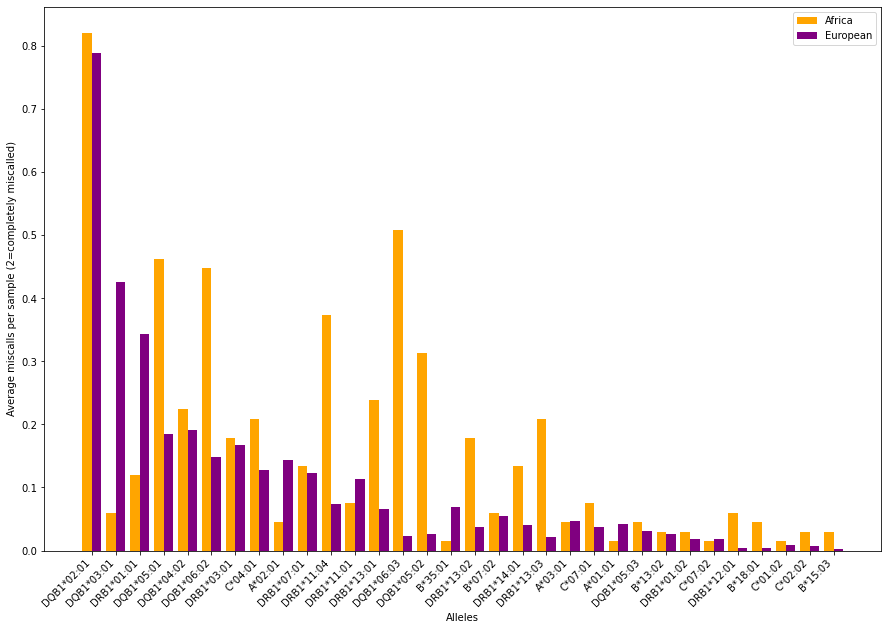

In [40]:
  
xaxis = np.arange(len(allele))
 
# plot bars in stack manner
plt.figure(figsize = (15,10))

plt.bar(xaxis - 0.2, yoruba.astype(float), 0.4,color='orange')
plt.bar(xaxis + 0.2, europe.astype(float), 0.4, color='purple')
plt.legend(["Africa","European"])
plt.xticks(xaxis,allele,rotation=45, ha='right')
plt.xlabel("Alleles")
plt.ylabel("Average miscalls per sample (2=completely miscalled)")

plt.show()